# Elena's EDA notebook

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

# Transformers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, recall_score, f1_score
from sklearn.metrics import classification_report, accuracy_score

# Pipelines
from imblearn.pipeline import Pipeline, make_pipeline

# SMOTE
from imblearn.over_sampling import SMOTE

In [2]:
import sys

sys.path.append("../../src")

from model_evaluation import plot_confusion_matrix

# Data Preprocessing 

In [167]:
clean_df = pd.read_csv('../../data/targeted_combined.csv')
clean_df.head()

,emotion,txt_cleaned
0,0.0,product_target hr tweet riseaustin dead need u...
1,2.0,know awesome ipadiphone product_target youll l...
2,2.0,wait product_target also sale sxsw
3,0.0,hope year festival isnt crashy year iphone pro...
4,2.0,great stuff fri sxsw marissa mayer product_tar...


In [168]:
clean_df['emotion'].value_counts()

2.0    8213
0.0    8062
1.0    6331
Name: emotion, dtype: int64

In [169]:
clean_df.isna().sum()

emotion        0
txt_cleaned    0
dtype: int64

In [170]:
# divides data into feature X and target y 

X = clean_df['txt_cleaned'].values.astype('U')
y = clean_df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.25)

# FSM: Multinomial Naive Bayes

The first simple model was run using Multinomial Naive Bayes classifier with unbalanced original data.
Note: the data is not uploaded in this notebook.

In [33]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_t_vec)
accuracy_score(y_t, y_hat)

0.8622511174319383

In [98]:
y_hat2 = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.8355663824604141

In [34]:
X_t_vec.sample(1).max(axis = 1)

4732    0.817702
dtype: float64

In [99]:
confusion_matrix(y_val, y_hat2)

array([[ 14,   0, 116],
       [  0,   0,  19],
       [  0,   0, 672]])

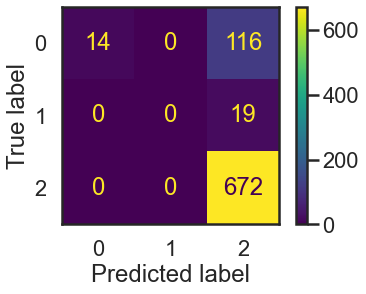

In [100]:
plot_confusion_matrix(mnb, X_val_vec, y_val)

### First Simple Model Evaluation
It reaches a 83% accuracy; however, the data is heavily unbalanced. Need to add more data. 

# Multinomial Naive Bayes

Running the model with new clean data set

### TF-IDF Vectorizer

You can read more about TF-IDF method on wikipedia: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

We will use pipeline for hyperparameter tuning and use grid search to find the best combination.
TF-IDF hyperparameters that we will tune are: 
- n-gram range: (1,1) unigrams (one word), (2,2) bigrams (two adjacent words), (3,3) trigrams (three adjacent words) and their combinations (1,2) and (2,3). 
- maximum document frequency set to 1%, 5% and 25% that means it will ignore temrs that appear in more than given percentage of the documents.
- minimum document frequency set to 1 and 2 that means it will ignore temrs that appear in less than given number of the documents.
- normalization method

Naive Bayes hyperparameter:
- alpha from additive (Laplace/Lidstone) smoothing parameter to closer no smoothing.

In [171]:
pipeline_nb_tf = make_pipeline(TfidfVectorizer(), MultinomialNB())
pipeline_nb_tf

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [172]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
# Define the parameter grid
grid_nb_tf = {
    'tfidfvectorizer__min_df': [1, 2],
    'tfidfvectorizer__max_df': [0.01, 0.05, 0.25],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2), (2,2), (2,3), (3,3)],
    'tfidfvectorizer__norm': ('l1', 'l2'),
    'multinomialnb__alpha': [1, 0.1, 0.01, 0.001]   
}

In [173]:
gs_nb_tf = GridSearchCV(pipeline_nb_tf, grid_nb_tf, cv=3)

In [174]:
gs_nb_tf.fit(X_t, y_t)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [1, 0.1, 0.01, 0.001],
                         'tfidfvectorizer__max_df': [0.01, 0.05, 0.25],
                         'tfidfvectorizer__min_df': [1, 2],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2), (2, 3),
                                                          (3, 3)],
                         'tfidfvectorizer__norm': ('l1', 'l2')})

In [175]:
gs_nb_tf.best_params_

{'multinomialnb__alpha': 0.1,
 'tfidfvectorizer__max_df': 0.25,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__norm': 'l2'}

In [176]:
gs_nb_tf.best_estimator_

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.25, ngram_range=(1, 2))),
                ('multinomialnb', MultinomialNB(alpha=0.1))])

In [177]:
#gs_nb_tf.fit(X_val, y_val)

In [178]:
y_pred_nb_tf = gs_nb_tf.predict(X_val)
accuracy_score(y_val, y_pred_nb_tf)

0.6350554376032083

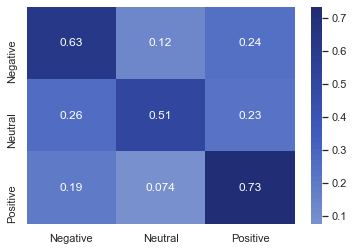

In [179]:
plot_confusion_matrix(y_val,y_pred_nb_tf)

In [180]:
gs_nb_tf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [1, 0.1, 0.01, 0.001],
                         'tfidfvectorizer__max_df': [0.01, 0.05, 0.25],
                         'tfidfvectorizer__min_df': [1, 2],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2), (2, 3),
                                                          (3, 3)],
                         'tfidfvectorizer__norm': ('l1', 'l2')})

In [181]:
y_pred_nb_tf_test = gs_nb_tf.predict(X_test)
accuracy_score(y_test, y_pred_nb_tf_test)

0.6411889596602972

In [182]:
gs_nb_tf.best_score_

0.6264594019960018

In [183]:
gs_nb_tf.best_estimator_.score(X_test, y_test)

0.6411889596602972

In [184]:
gs_nb_tf.cv_results_

{'mean_fit_time': array([0.13005884, 0.12064219, 0.29061373, 0.33225457, 0.26413472,
        0.23642937, 0.4290487 , 0.42938463, 0.23524499, 0.23772295,
        0.11130301, 0.11185002, 0.25120139, 0.21740635, 0.17375263,
        0.18315212, 0.29774801, 0.31146526, 0.181451  , 0.185371  ,
        0.1278367 , 0.1232206 , 0.32880966, 0.35116927, 0.24027729,
        0.24968028, 0.44193594, 0.42680939, 0.2692097 , 0.29721983,
        0.15509208, 0.12789718, 0.2798117 , 0.27448996, 0.19264523,
        0.19478019, 0.30511562, 0.28742727, 0.17032846, 0.17027632,
        0.13673782, 0.12941138, 0.32021658, 0.33117421, 0.24737708,
        0.25902073, 0.46250232, 0.4634347 , 0.27067343, 0.25880814,
        0.118457  , 0.11813378, 0.24939553, 0.24876992, 0.18418868,
        0.19178828, 0.28687708, 0.27809366, 0.16003505, 0.16540766,
        0.12566272, 0.13363616, 0.29906869, 0.29383906, 0.24167196,
        0.24749835, 0.43800712, 0.42151475, 0.24759277, 0.23769204,
        0.12030117, 0.12801973,

### Count Vectorizer

The only difference of the Count Vectorizer from the TF-IDF Vectorizer it returns integers instead of floats.

We will take same steps and use same hyperparameters as for TF-IDF. 
Count Vectorizer hyperparameters that we will tune are: 
- n-gram range: (1,1) unigrams (one word), (2,2) bigrams (two adjacent words), (3,3) trigrams (three adjacent words) and their combinations (1,2) and (2,3). 
- maximum document frequency set to 1%, 5% and 25% that means it will ignore temrs that appear in more than given percentage of the documents.
- minimum document frequency set to 1 and 2 that means it will ignore temrs that appear in less than given number of the documents.

Naive Bayes hyperparameter:
- alpha from additive (Laplace/Lidstone) smoothing parameter to closer no smoothing.

In [185]:
pipeline_nb_cv = make_pipeline(CountVectorizer(), MultinomialNB())
pipeline_nb_cv

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [186]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
# Define the parameter grid
grid_nb_cv = {
    'countvectorizer__min_df': [1, 2],
    'countvectorizer__max_df': [0.1, 0.5, 0.25],
    'countvectorizer__ngram_range': [(1,1), (1,2), (2,2), (2,3), (3,3)],
    'multinomialnb__alpha': [1, 0.1, 0.01]   
}

In [187]:
# Initialize the gridsearch object with three-fold cross-validation
gs_nb_cv = GridSearchCV(pipeline_nb_cv, grid_nb_cv, cv=3)

In [188]:
gs_nb_cv.fit(X_t, y_t)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'countvectorizer__max_df': [0.1, 0.25],
                         'countvectorizer__min_df': [1, 2],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2), (2, 3),
                                                          (3, 3)],
                         'multinomialnb__alpha': [1, 0.1, 0.01]})

In [189]:
gs_nb_cv.best_params_

{'countvectorizer__max_df': 0.25,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 2),
 'multinomialnb__alpha': 1}

In [190]:
gs_nb_cv.best_estimator_

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.25, ngram_range=(1, 2))),
                ('multinomialnb', MultinomialNB(alpha=1))])

In [191]:
y_pred_nb_cv = gs_nb_cv.predict(X_val)
accuracy_score(y_val, y_pred_nb_cv)

0.6407171502712904

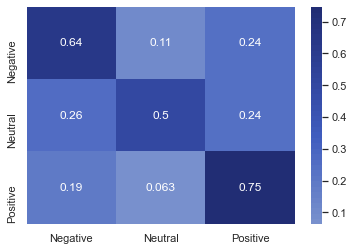

In [192]:
plot_confusion_matrix(y_val,y_pred_nb_cv)

In [193]:
gs_nb_cv.best_score_

0.6202133325080195

In [194]:
gs_nb_cv.best_estimator_.score(X_val, y_val)

0.6407171502712904

In [195]:
gs_nb_cv.cv_results_

{'mean_fit_time': array([0.09941761, 0.08810504, 0.08813   , 0.23552068, 0.27986805,
        0.29647104, 0.19499667, 0.19400001, 0.19873929, 0.37063487,
        0.36168528, 0.32331562, 0.18750874, 0.21298965, 0.19118301,
        0.09177399, 0.08978979, 0.09080919, 0.18269237, 0.17814088,
        0.17770092, 0.13424333, 0.13354071, 0.13968428, 0.22619963,
        0.22509774, 0.20908125, 0.12819195, 0.12571152, 0.12583598,
        0.10708102, 0.10248303, 0.10446501, 0.25982364, 0.25395393,
        0.23439606, 0.18032328, 0.17984422, 0.18071874, 0.33047533,
        0.33718506, 0.338461  , 0.1869007 , 0.18719872, 0.19262306,
        0.09729369, 0.09364835, 0.09063832, 0.17839495, 0.17990804,
        0.17822472, 0.13265498, 0.13375163, 0.13894773, 0.21729604,
        0.20615721, 0.20525448, 0.12517341, 0.12471334, 0.12501963]),
 'std_fit_time': array([0.01244249, 0.00110012, 0.0007952 , 0.0126191 , 0.02082054,
        0.04181772, 0.00231564, 0.00295524, 0.00626185, 0.0148767 ,
        0.004

In [196]:
gs_nb_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'countvectorizer__max_df': [0.1, 0.25],
                         'countvectorizer__min_df': [1, 2],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2), (2, 3),
                                                          (3, 3)],
                         'multinomialnb__alpha': [1, 0.1, 0.01]})

In [197]:
y_pred_nb_cv_test = gs_nb_cv.predict(X_test)
accuracy_score(y_test, y_pred_nb_cv_test)

0.642073602264685

### MNB Model Evaluation
It reaches the best result of 64.2% accuracy with Count Vectorizer. It identifies positive emotions with 75% of accuracy better than negative with 65% and 50% of neutral emotions.  

# Logistic Regression

Let's run Logistic Regression 

We will need to convert our text data. Also, will use Count and TF-IDF vectorizers before running the model.

In [235]:
# Count Vectorizer ngram range is chosen (1,2) based on 
# Multinomial NB pipeline best parameters and it shows the best results for Logistic Regression as well 

cv = CountVectorizer(ngram_range = (1,2))
X_t_vec = cv.fit_transform(X_t)
X_val_vec = cv.transform(X_val)

X_train_vec = cv.fit_transform(X_train)
X_test_vec = cv.transform(X_test)

In [229]:
# Count Vectorizer performs slightly better than TF-IDF, no need to run this cell

tfidf = TfidfVectorizer(ngram_range = (1,2))
X_t_vec = tfidf.fit_transform(X_t)
X_val_vec = tfidf.transform(X_val)

In [230]:
#lr = LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', solver ='lbfgs')
#lr.fit(X_t_vec, y_t)

In [236]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_t_vec, y_t)

LogisticRegression(max_iter=1000)

In [237]:
y_pred_lg = lr.predict(X_val_vec)
accuracy_score(y_val, y_pred_lg)

0.6534560037744751

In [238]:
unique, counts = np.unique(y_pred_lg, return_counts=True)
dict(zip(unique, counts))

{0.0: 1530, 1.0: 1097, 2.0: 1612}

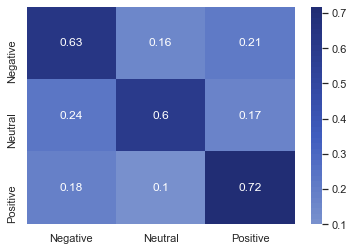

In [239]:
plot_confusion_matrix(y_val,y_pred_lg)

In [240]:
# Full train data

lr.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [241]:
# Test data

y_pred_lg = lr.predict(X_test_vec)
accuracy_score(y_test, y_pred_lg)

0.6597664543524416

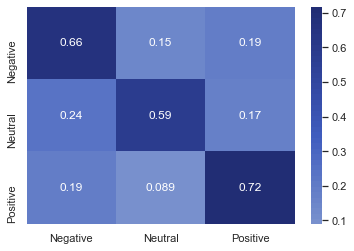

In [242]:
plot_confusion_matrix(y_test,y_pred_lg, save_path='../../reports/figures/logreg_cfm.png')

In [17]:
import pickle 
  
# Save the trained model as a pickle string. 
with open('../../src/final_model.pkl', 'wb') as f:
    pickle.dump(lr, f)


In [207]:
lr_neg_emotion_sorted = lr.coef_[0, :].argsort()
lr_no_emotion_sorted = lr.coef_[1, :].argsort()
lr_pos_emotion_sorted = lr.coef_[2, :].argsort()

print(np.take(cv.get_feature_names(), lr_neg_emotion_sorted[-10:]))
print(np.take(cv.get_feature_names(), lr_no_emotion_sorted[-10:]))
print(np.take(cv.get_feature_names(), lr_pos_emotion_sorted[-10:]))

['crash' 'fuck' 'phone' 'battery' 'fix' 'suck' 'impressed' 'charger'
 'weak' 'brutality']
['skit' 'who go' 'joke' 'patent' 'december' 'aapl' 'funny' 'parody'
 'hilarious' 'meme']
['ridiculous' 'amazing' 'amaze' 'cant wait' 'congrats' 'cheat' 'tired'
 'cheatriots' 'cheater' 'sxsw']


In [208]:
lr_neg_emotion_sorted = lr.coef_[0, 0].argsort()
#lr_no_emotion_sorted = lr.coef_[1, :].argsort()
#lr_pos_emotion_sorted = lr.coef_[2, :].argsort()

print(np.take(cv.get_feature_names(), lr_neg_emotion_sorted[-10:]))
#print(np.take(cv.get_feature_names(), lr_no_emotion_sorted[-10:]))
#print(np.take(cv.get_feature_names(), lr_pos_emotion_sorted[-10:]))

['aa']


### Logistic Regression Model Evaluation
Logistic Regression performs better that Multinomial NB. It reaches a 66% accuracy with over 59% in each category. It identifies positive emotions the best.

# Random Forest

We use the same vectorized data sets as for logisitic regression. 

In [211]:
pipeline = make_pipeline(SMOTE(), RandomForestClassifier())
pipeline

Pipeline(steps=[('smote', SMOTE()),
                ('randomforestclassifier', RandomForestClassifier())])

In [212]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
# Define the parameter grid
grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ["auto", "sqrt", "log2"],
    'randomforestclassifier__criterion' : ["gini", "entropy"]
    
}

In [213]:
# Initialize the gridsearch object with three-fold cross-validation
gs = GridSearchCV(pipeline, grid, cv=5)

In [108]:
gs.fit(X_t_vec, y_t)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_features': ['auto',
                                                                  'sqrt',
                                                                  'log2'],
                         'randomforestclassifier__n_estimators': [100, 200]})

In [162]:
gs.feature_importances_

NameError: name 'gs' is not defined

In [110]:
gs.best_params_

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 100}

In [111]:
gs.best_estimator_

Pipeline(steps=[('smote', SMOTE()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features='log2'))])

In [113]:
y_pred_rf = gs.predict(X_val_vec)
accuracy_score(y_val, y_pred_rf)

0.6588818117480538

In [114]:
gs.best_score_

0.6478961856075502

In [116]:
gs.best_estimator_.score(X_val_vec, y_val)

0.6588818117480538

In [117]:
plot_confusion_matrix(y_val,y_pred_rf)

{'mean_fit_time': array([24.09810796, 46.98651309, 23.82965741, 46.96558852, 30.54141326,
        60.18758368, 24.14386764, 47.78008571, 24.12288399, 47.88034105,
        30.74561791, 61.54912977]),
 'std_fit_time': array([0.46399792, 0.48555014, 0.30545791, 0.67445474, 0.56218861,
        0.69504875, 0.19558013, 0.48453492, 0.24535956, 0.48896532,
        0.41670831, 0.8124697 ]),
 'mean_score_time': array([0.18688397, 0.38112049, 0.18528314, 0.38103275, 0.39523625,
        0.8161778 , 0.19364052, 0.35234818, 0.17629061, 0.36424532,
        0.39457669, 0.84372158]),
 'std_score_time': array([0.01110443, 0.03167556, 0.00818125, 0.02730902, 0.01148001,
        0.03217504, 0.02045851, 0.00933749, 0.00407845, 0.02463659,
        0.01190103, 0.04368167]),
 'param_randomforestclassifier__criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini',
                    'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                    'entropy'],
              mask=[

Model with the best parameters

In [209]:
rf = RandomForestClassifier(n_estimators=1000, max_features='log2')
rf.fit(X_t_vec, y_t)

RandomForestClassifier(max_features='log2', n_estimators=1000)

In [210]:
y_hat = rf.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.6444916253833451

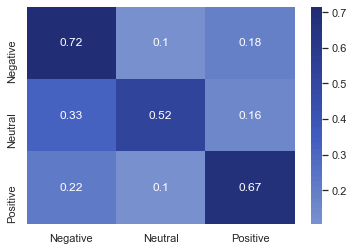

In [243]:
plot_confusion_matrix(y_val, y_hat)

### Random Forest Model Evaluation
Random Forest performs similar to Multinomial NB with it's best parameters, and worse than Logistic Regression. It reaches a 64.4% accuracy with over 52% in each category. Unlike previous models, it predicted negative emotions better than other two. It runs much slower than other two models, a big con for Random Forest.  

# Ensemble Learning

Let's run an ensemble model with all 3 classifiers together. 

In [72]:
clf1 = LogisticRegression(max_iter=1000, random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf3 = MultinomialNB()
eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('mnb', clf3)],
     voting='soft'
     )

In [73]:
# Parameters

params = {'lr__C': [1.0, 100.0], 
          'rf__n_estimators': [10, 100],
          'mnb__alpha': [1, 0.1, 0.01, 0.001] 
         }

In [74]:
grid = GridSearchCV(estimator=eclf, param_grid=params, cv=3)
grid = grid.fit(X_t_vec, y_t)

In [75]:
y_pred_ens = grid.predict(X_val_vec)
accuracy_score(y_val, y_pred_ens)

0.6676102854446804

In [77]:
grid.best_params_

{'lr__C': 1.0, 'mnb__alpha': 1, 'rf__n_estimators': 100}

In [78]:
grid.best_estimator_

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('mnb', MultinomialNB(alpha=1))],
                 voting='soft')

## Ensemble Model Evaluation
Ensemble model performed closest to logistic regression, but it was much slower with run time 40 minutes comparing to a few seconds. 

# Summary:
The best performed model is logistic regression using default parameters with Count Vectorizer tokenization in range (1,2) which means using unigrams (a single word) or and bigrams (two adjacent words). Also, logistic regression performs much faster than Multinomial NB and Random Forest, a few seconds compare to several minutes upto 40 minutes.  Our final model is predicting the sentiments of a tweet for a given product with the accuracy of 66.0%, and is particularly good at identifying positive tweets with 72% accuracy. People who will use this model can expect 2 of 3 accuracy predictions.